In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
import cv2
import keras
import tensorflow as tf
from tqdm import tqdm
from keras import Input, Model
from keras.layers import UpSampling2D, Reshape
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.callbacks import ModelCheckpoint
from keras.utils import generic_utils
from matplotlib import pyplot as plt

def resizeImg(path,newDir):
    imgList = os.listdir(path)
    for imgPath in tqdm(imgList):
        tmpPath = path+"/"+imgPath
        img = cv2.imread(tmpPath)
        img = cv2.resize(img,(256,256))
        tmpName = imgPath.split('.')
        cv2.imwrite(newDir+"/"+tmpName[0]+'.jpg',img)

def mosaicImg(path,newDir):
    imgList = os.listdir(path)
    for imgPath in tqdm(imgList):
        tmpPath = path+"/"+imgPath
        img = cv2.imread(tmpPath)
        mosaicPic = mosaic(img,85,85,105,105)
        cv2.imwrite(newDir+"/"+imgPath,mosaicPic)

def mosaic(img,x,y,w,h,neighbour = 14):
    for i in range(0,h - neighbour, neighbour):
        for j in range(0, w - neighbour,neighbour):
            box = [j+x,i+y,neighbour,neighbour]
            color = img[i+y][j+x].tolist()
            cv2.rectangle(img,(box[0],box[1]),(box[0]+neighbour-1,box[1]+neighbour-1),color,-1)
    return img

def preReadData(dataDir1,dataDir2):
    trainingData = []
    labelData = []
    for path in tqdm(os.listdir(dataDir1)):
        img = cv2.imread(dataDir1+"/"+path)
        trainingData.append(img)
    for path in tqdm(os.listdir(dataDir2)):
        img = cv2.imread(dataDir2+"/"+path)
        labelData.append(img)
    np.save('trainingData.npy',np.asarray(trainingData))
    np.save('labelData.npy',np.asarray(labelData))

def processImg(imgData):
    res = []
    for img in imgData:
        img = img / 255 - 0.5
        res.append(img)
    return np.asarray(res)

def loadData(trainingPath,labelPath,batch_size):
    trainingData = np.load(trainingPath)
    labelData =  np.load(labelPath)
    while True:
        for i in range(0,len(trainingData),batch_size):
            trainingImg = processImg(trainingData[i:i+batch_size])
            labelImg = processImg(labelData[i:i+batch_size])
            yield(trainingImg,labelImg)
   

def DeMosaicModel():
    encoderInput = Input(shape = (256,256,3,))
#------Encoder------------
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(encoderInput)
    x = Conv2D(16, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
    x = Conv2D(32, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=1)(x)
    x = Conv2D(256, (4, 4), activation='relu', padding='same', strides=2)(x)

#------Decoder------------
    x = Conv2DTranspose(256, (3,3), activation='relu', padding = 'same',strides = 2)(x)
    x = Conv2DTranspose(128, (3,3), activation='relu', padding = 'same',strides = 1)(x)
    x = Conv2DTranspose(128, (2,2), activation='relu', padding = 'same',strides = 2)(x)
    x = Conv2DTranspose(64, (2,2), activation='relu', padding = 'same',strides = 2)(x)
    x = Conv2DTranspose(64, (2,2), activation='relu', padding = 'same',strides = 2)(x)
    x = Conv2DTranspose(32, (1,1), activation='relu', padding = 'same',strides = 1)(x)
    x = Conv2DTranspose(32, (2,2), activation='relu', padding = 'same',strides = 2)(x)
    x = Conv2DTranspose(16, (1,1), activation='relu', padding = 'same',strides = 1)(x)
    x = Conv2DTranspose(16, (2,2), activation='relu', padding = 'same',strides = 2)(x)
    encoderOutput = Conv2DTranspose(3, (1,1), activation='tanh', padding = 'same',strides = 1)(x)

    model = Model(inputs = encoderInput,outputs = encoderOutput)
    model_optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(optimizer=model_optimizer, loss='mse', metrics=['accuracy'])

    return model

def train(modelPath = '/content/drive/My Drive/Colab Notebooks/model/Demosaic.hdf5',batch_size = 50):
    model = DeMosaicModel()
    if os.path.exists(modelPath):
        model.load_weights(modelPath)
        print("Check point loaded!")
    trainingPath = "/content/drive/My Drive/Colab Notebooks/trainingData.npy"
    labelPath = "/content/drive/My Drive/Colab Notebooks/labelData.npy"
    dataGen = loadData(trainingPath,labelPath,batch_size)
    r_epochs = 0
    num_epochs = 200
    epoch_length = 228
    bestLoss = np.Inf
    iter_num = 0
    loss_record = []
    acc_record = []
    losses = np.zeros((epoch_length, 2))
    for epoch_num in range(num_epochs):
        progbar = generic_utils.Progbar(epoch_length)
        print('Epoch {}/{}'.format(r_epochs + 1, num_epochs))
        r_epochs += 1
        while True:
            X,Y = next(dataGen)
            modelLoss = model.train_on_batch(X,Y)
            losses[iter_num, 0] = modelLoss[0]
            losses[iter_num, 1] = modelLoss[1]
            
            iter_num += 1
            progbar.update(iter_num, [('loss', np.mean(losses[:iter_num, 0])), ('acc', np.mean(losses[:iter_num, 1]))])
            if iter_num == epoch_length:
                loss_record.append(np.mean(losses[:iter_num, 0]))
                acc_record.append(np.mean(losses[:iter_num, 1]))
                if modelLoss[0] < bestLoss:
                    model.save_weights(modelPath)
                iter_num = 0
                break
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, len(loss_record)), loss_record, 'r')
    plt.title('loss')

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, len(acc_record)), acc_record, 'r')
    plt.title('acc')

    plt.show()

def predict(modelPath = '/content/drive/My Drive/Colab Notebooks/model/Demosaic.hdf5',testDataPath = '/content/drive/My Drive/Colab Notebooks/test',OutputPath = '/content/drive/My Drive/Colab Notebooks/output',groundTruthPath = '/content/drive/My Drive/Colab Notebooks/correct'):
    model = DeMosaicModel()
    if os.path.exists(modelPath):
        model.load_weights(modelPath)
        print("Model loaded!")
        testData = []
        groundTruthData = []
        for path in tqdm(os.listdir(testDataPath)):
            gtImg = groundTruthPath+"/"+path
            gtImg = cv2.imread(gtImg)
            gtImg = gtImg / 255 - 0.5
            groundTruthData.append(gtImg)
            testImg = testDataPath+"/"+path
            testImg = cv2.imread(testImg)
            testImg = testImg / 255 - 0.5
            testData.append(testImg)
            testIn = np.asarray(testImg)
            x = np.expand_dims(testIn, axis=0)
            y = model.predict([x])
            y = y[0]
            img = 255 * (y + 0.5)
            #cv2.imwrite(OutputPath+"/"+path,img)

        testData = np.asarray(testData)
        groundTruthData = np.asarray(groundTruthData)
        resultImg = model.predict([testData])
        mse_loss = tf.keras.losses.mean_squared_error(groundTruthData, resultImg)
        print(np.mean(mse_loss))
        
    else:
        return



In [ ]:
model = DeMosaicModel()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      4112      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        16416     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)       

Epoch 1/200
228/228 [==============================] - 177s 775ms/step - loss: 0.0810 - acc: 0.6762
Epoch 2/200
228/228 [==============================] - 77s 339ms/step - loss: 0.0168 - acc: 0.6934
Epoch 3/200
228/228 [==============================] - 76s 332ms/step - loss: 0.0131 - acc: 0.7013
Epoch 4/200
228/228 [==============================] - 76s 332ms/step - loss: 0.0118 - acc: 0.7051
Epoch 5/200
228/228 [==============================] - 77s 336ms/step - loss: 0.0111 - acc: 0.7007
Epoch 6/200
228/228 [==============================] - 77s 339ms/step - loss: 0.0102 - acc: 0.7197
Epoch 7/200
228/228 [==============================] - 76s 335ms/step - loss: 0.0090 - acc: 0.7548
Epoch 8/200
228/228 [==============================] - 76s 334ms/step - loss: 0.0072 - acc: 0.7948
Epoch 9/200
228/228 [==============================] - 76s 335ms/step - loss: 0.0068 - acc: 0.8003
Epoch 10/200
228/228 [==============================] - 77s 339ms/step - loss: 0.0063 - acc: 0.8067
Epoch 11

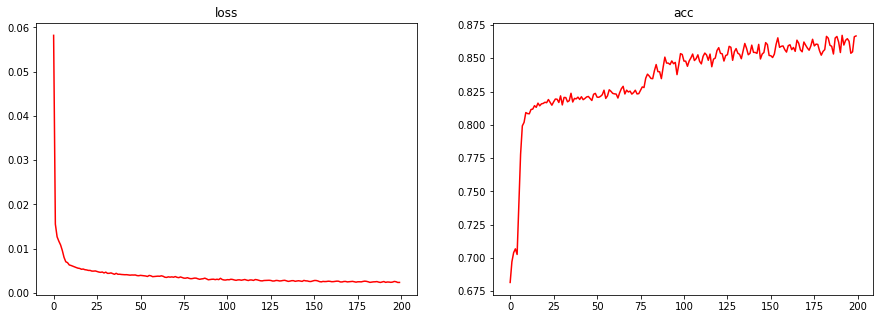

In [ ]:
train()

In [3]:
predict()

Model loaded!


100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s]


0.0026895062
